# PyExtal example for CBED refinement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import farid
from pyextal.dinfo import CBEDDiffractionInfo
from pyextal.roi import CBEDROI


from pyextal.optimize import CoarseOptimize, FineOptimize
from pyextal.gof import Chi2_multibackground
plt.rcParams['image.cmap'] = 'inferno'

pyextal package imported. Version: 0.0.1


### load data
1. load the input data
2. load the mtf for the detector
3. display the data

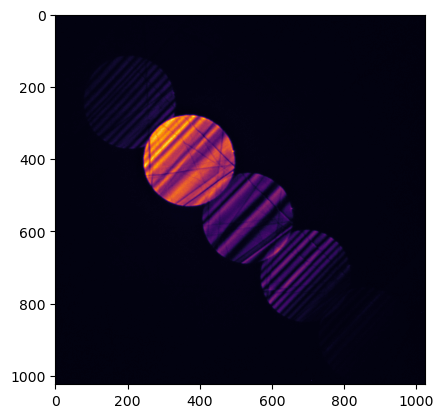

In [2]:
data = np.fromfile("../box/Si_systematics/si04.img", dtype='<f4', offset=8).reshape(1024, 1024).byteswap()
mtf = np.load('../box/YAG 120 CCD MTF.npy')

plt.imshow(data)

### set detector parameters
- set the detector parameters, check [Electron Detection Characteristics of a Slow-Scan CCD Camera, Imaging Plates and Film, and Electron Image Restoration](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/) for what the parameters mean
   - varB
   - delta
   - A
   - g
   - m
- background for Lucy-Richardson deconvolution (currently not used)


In [3]:
dtpar = [3.15, 4e-5, 1.2, 2.2, 0.111]
background = 38.0681229


### initialize diffraction info class
- stores dp
- initial guess of thickness
- additional tilt x and y
- geometry scaling
- .dat file path
- detector parameters
- mtf shape
- background for Lucy-Richardson deconvolution

In [4]:
dinfo = CBEDDiffractionInfo(data, 3431.99,  0, 0, 226.7, 'test_case/Si_systematic.dat', dtpar, mtf, background,)

### region of interest parameters:
defines the region of interest for refinement
- rotation: relative to the xaxis set in .dat
- gInclude: list of g-vectors to include in the refinement
- dpCenter: of diffraction pattern for simulation as reference point
- dpSize: size of the diffraction pattern for simulation

In [5]:
rotation = 44.742
dpCenter = [250, 450]
dpSize = [500,1200]

- gx: the horizontal axis for simulation

include beam initialized
group symmetry initialized


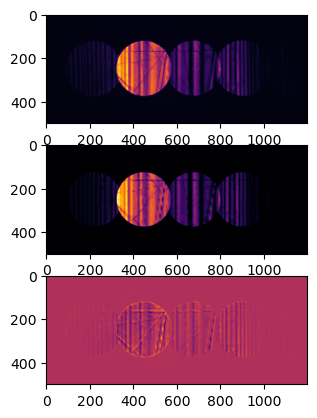

In [6]:
roi = CBEDROI(dinfo=dinfo, rotation=rotation, gx=np.array([1,-1,-1]), gInclude=[(-1,1,1),(0,0,0),(1,-1,-1),(2,-2,-2)], dpCenter=dpCenter, dpSize=dpSize) 

select the region of interest for refinement
- regions: define 3 points relative to dpCenter to defeine a parallelogram, multiple regions can be defined, [[region1_top_left, region1_top_right, region1_bottom_left, pixels],  
 [region2_top_left, region2_top_right, region2_bottom_left], ...]  
region_top_left = [row, column]  
pixels = [pixels_row, pixels_column]

- mask: whether to include the region for each reflection selected in nthgx [[region1_beam1, region1_beam2, ...], [region2_beam1, region2_beam2, ...], ...], 1 include, 0 exclude

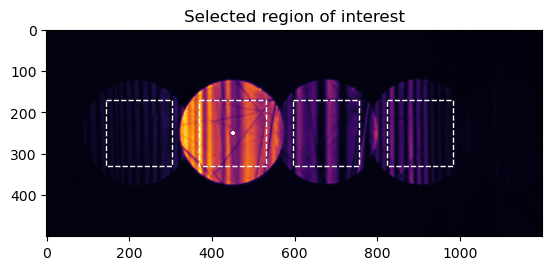

In [7]:
roi.selectROI(np.array([[[-80,-80], [-80, 80], [80,-80], [160,160]]]))
roi.displayROI()

### initialize coarse refine
- only support rectangular ROI, and only one region

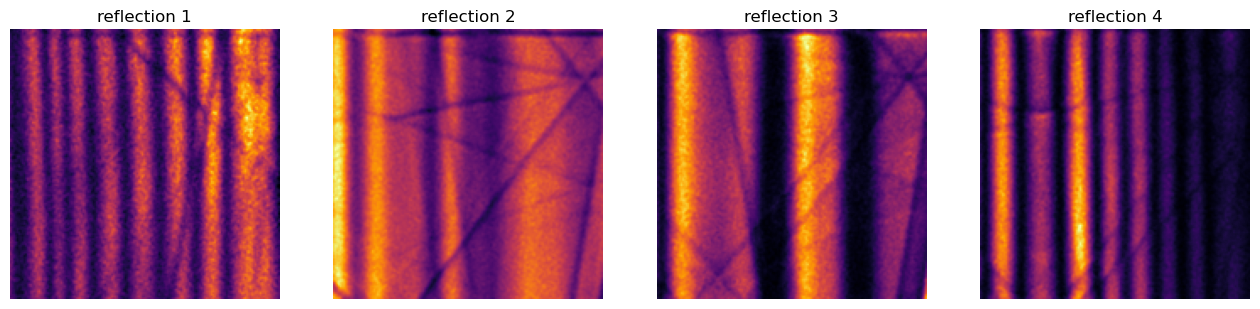

In [8]:
coarse = CoarseOptimize(dinfo=dinfo, roi=roi, searchRadius=0.7, nx=60)

In [9]:
coarse.optimizeOrientationThickness()


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
thickness: 3433.1703399999997, gl: 226.7, tiltY: -0.018218052064882362, tiltX: 0.0060726840216274725


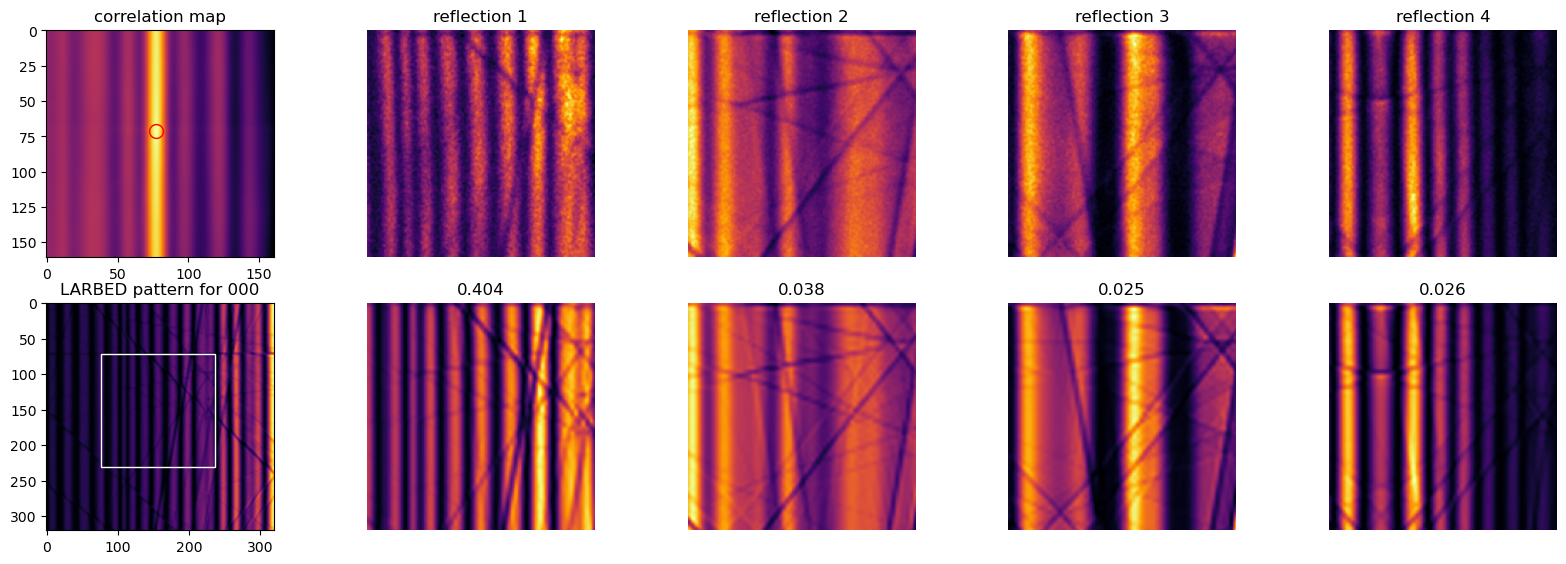

In [10]:
coarse.displayCoarseSearch()

In [ ]:
_, h, w = coarse.templates.shape
np.save("../box/Si_systematics/sim.npy", coarse.exitwave[:,coarse.loc[0]:coarse.loc[0]+h, coarse.loc[1]:coarse.loc[1]+w])

(71, 77)


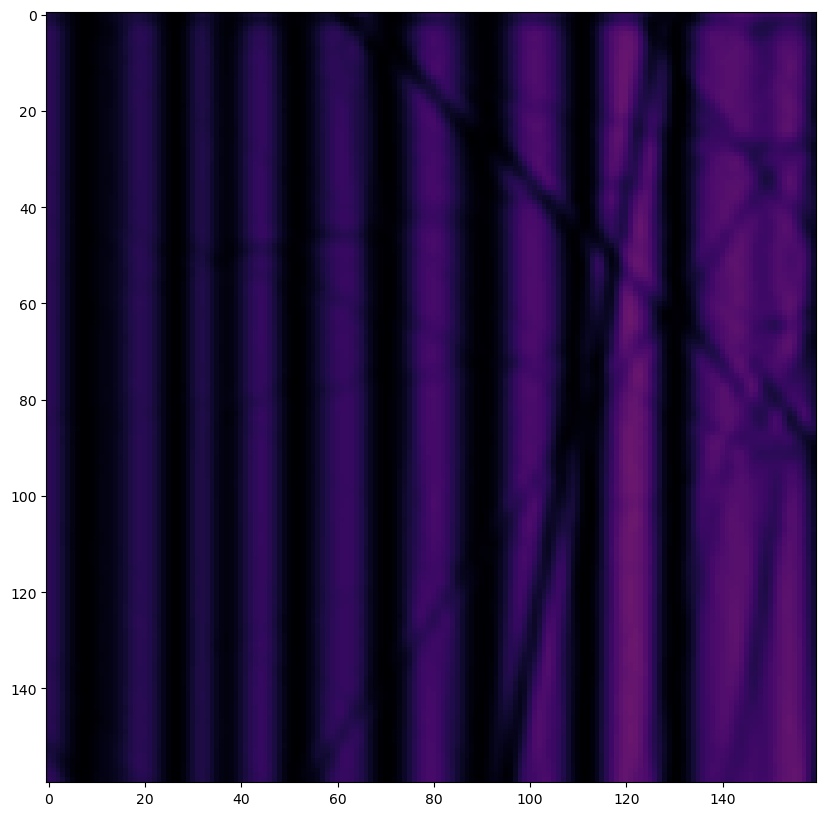

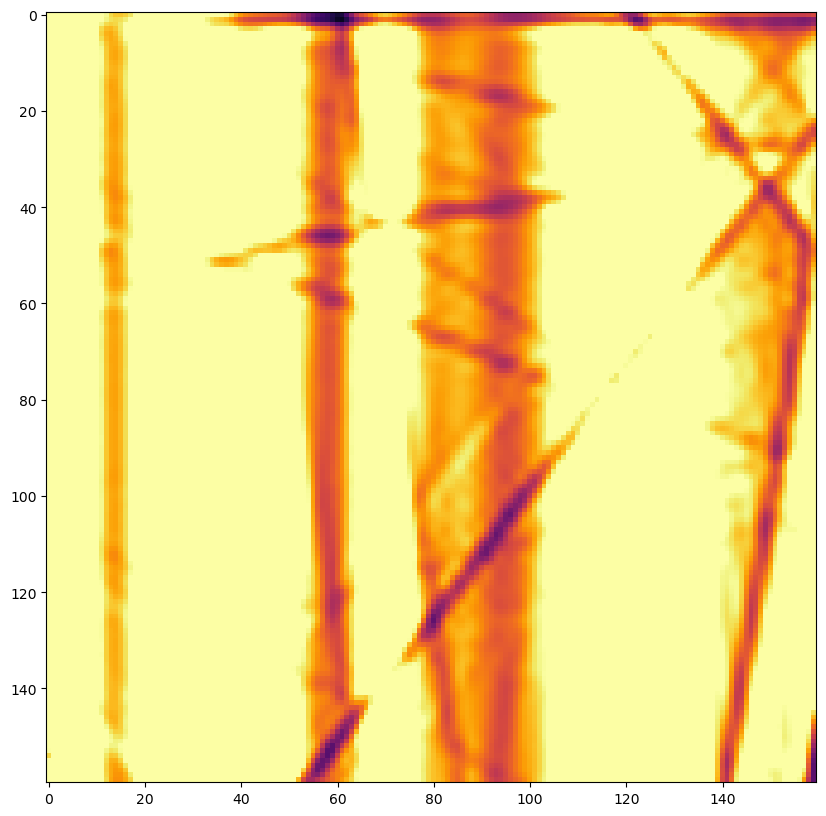

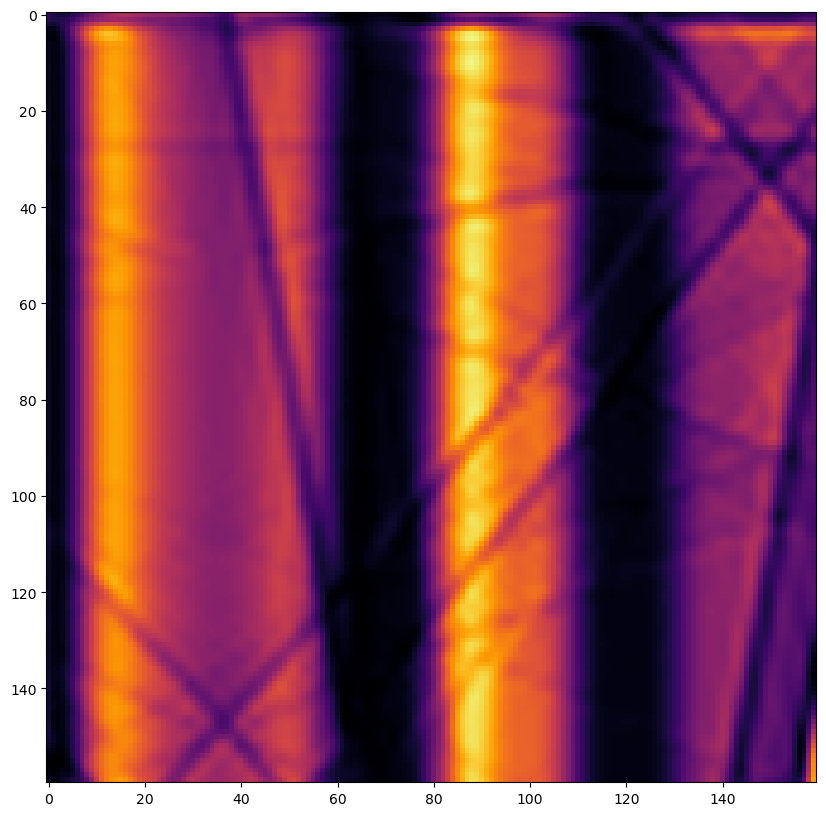

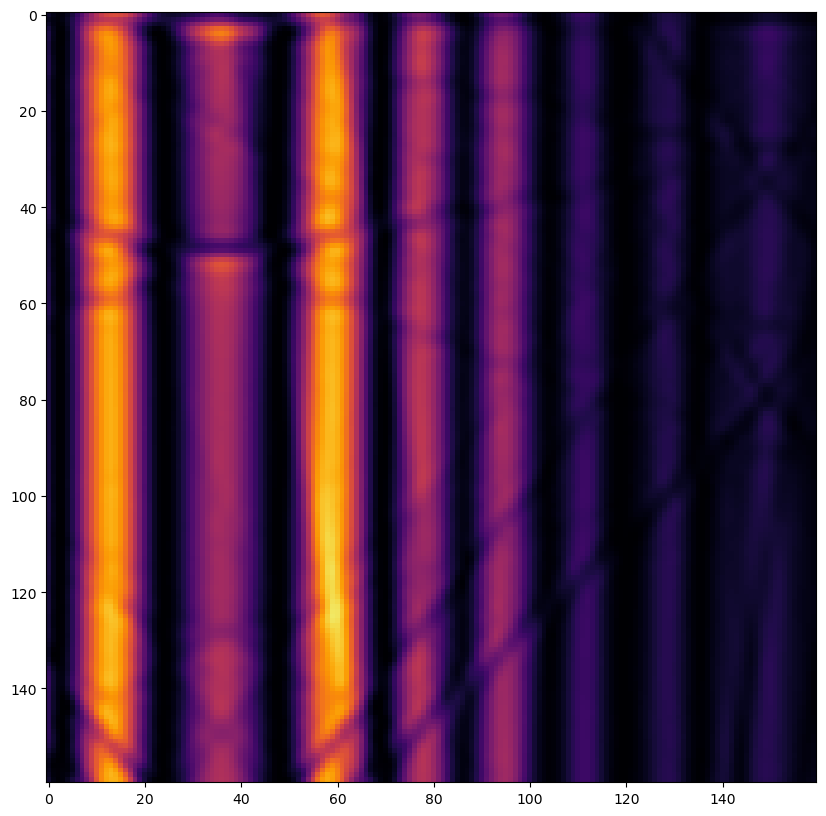

In [ ]:
_, h, w = coarse.templates.shape
print(coarse.loc)
for sim in coarse.exitwave:
    crop = sim[coarse.loc[0]:coarse.loc[0]+h, coarse.loc[1]:coarse.loc[1]+w]
    plt.figure(figsize=(10, 10))
    plt.imshow(crop, vmin=0, vmax=0.5)


In [ ]:
roi.setTilt0(np.array([12.1174, -12.1174,  25.7133]), np.array([423,453]))

[701.68185893 619.51478208]


In [14]:
roi.transformDP(roi.kt2pixel(np.array([12.1174, -12.1174,  25.7133]))*roi.initPixsiz/roi.pixsiz + roi.dpCenter)

array([[423.0000056 , 453.00001299]])

In [13]:
res = roi.kt2pixel(np.array([[11.7871, -11.7871, 27.0524], 
                             [12.6021, -12.6021, 26.2374],
                             [11.62504, -11.62504, 26.79022],
                             [12.35222, -12.35222, 26.01719],
                             [11.9400, -11.9400, 26.8801],
                             [11.834, -11.834,  26.668],
                             [12.4400, -12.4400, 26.3801],
                             [12.334, -12.334,  26.168],
                             [11.81386, -11.81386, 25.62702],
                             [11.82949, -11.82949, 25.54558],
                             [11.57420, -11.57420, 26.00951],
                             [11.53726, -11.53726, 25.95375],
                             [12.07578, -12.07578, 25.50610],
                             [12.03540, -12.03540, 25.43397],
                             [11.77627, -11.77627, 27.16149],
                             [11.78658, -11.78658, 27.07873],
                             [11.86124, -11.86124, 25.99334],
                             [11.89499, -11.89499, 26.07191],
                             [11.86057, -11.86057, 27.10300],
                             [11.85281, -11.85281, 27.16308],
                             [12.41354, -12.41354, 26.13605],
                             [12.47972, -12.47972, 26.09106],
                             [12.50270, -12.50270, 26.42296],
                             [12.56888, -12.56888, 26.37797]]))
points = [101,101,21,21,17,17,17,17,17,17,17,17]
for endpoints, p in zip(res.reshape(-1, 2, 2), points):
    print(f'[[{endpoints[0][0]:.5f}, {endpoints[0][1]:.5f}], [{endpoints[1][0]:.5f}, {endpoints[1][1]:.5f}], [{endpoints[0][0]:.5f}, {endpoints[0][1]:.5f}], [{p}, 1]], ')
# print(roi.kt2pixel(np.array([[12.6021, -12.6021, 26.2374]])))

[[51.39757, -79.46768], [51.39757, 105.29283], [51.39757, -79.46768], [101, 1]], 
[[6.06014, -84.14828], [1.16027, 84.16817], [6.06014, -84.14828], [101, 1]], 
[[49.32434, -43.33925], [15.32982, -43.33170], [49.32434, -43.33925], [21, 1]], 
[[49.32434, 70.01075], [15.32982, 70.01831], [49.32434, 70.01075], [21, 1]], 
[[-98.06933, 32.28787], [-105.10227, 40.80424], [-98.06933, 32.28787], [17, 1]], 
[[-82.80546, -32.83624], [-92.71207, -34.20551], [-82.80546, -32.83624], [17, 1]], 
[[-83.00102, 81.01024], [-95.02468, 80.35810], [-83.00102, 81.01024], [17, 1]], 
[[61.89836, -89.34802], [54.15581, -81.53594], [61.89836, -89.34802], [17, 1]], 
[[-53.85828, 11.76699], [-41.85493, 10.93046], [-53.85828, 11.76699], [17, 1]], 
[[64.65661, -72.18759], [70.24791, -77.90043], [64.65661, -72.18759], [17, 1]], 
[[20.41564, 84.45381], [22.68016, 97.85556], [20.41564, 84.45381], [17, 1]], 
[[60.60526, 76.24803], [62.86978, 89.64978], [60.60526, 76.24803], [17, 1]], 


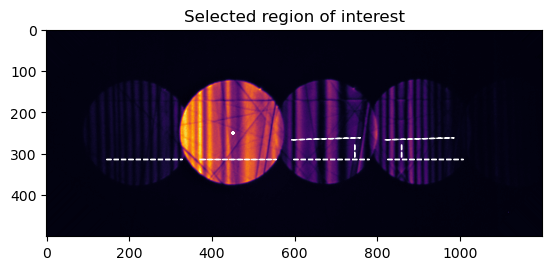

In [11]:

roi.selectROI(np.array([
[[61.48970, -80.59588], [61.48970, 104.16463], [61.48970, -80.59588], [101, 1]], 
[[16.15227, -85.27648], [11.25240, 83.03997], [16.15227, -85.27648], [101, 1]], 
[[59.41647, -44.46745], [25.42195, -44.45989], [59.41647, -44.46745], [21, 1]], 
[[59.41647, 68.88256], [25.42195, 68.89011], [59.41647, 68.88256], [21, 1]],]),
                       mask=np.array([[1,1,1,1],[0,0,1,1],[0,0,0,1],[0,0,1,0], ]))

roi.displayROI()

In [14]:
roi.simGrid

array([[ 11.81674247, -11.81674247,  27.11361064],
       [ 11.82489247, -11.82489247,  27.10546064],
       [ 11.83304247, -11.83304247,  27.09731064],
       [ 11.84119247, -11.84119247,  27.08916064],
       [ 11.84934247, -11.84934247,  27.08101064],
       [ 11.85749248, -11.85749248,  27.07286064],
       [ 11.86564248, -11.86564248,  27.06471063],
       [ 11.87379248, -11.87379248,  27.05656063],
       [ 11.88194248, -11.88194248,  27.04841063],
       [ 11.89009248, -11.89009248,  27.04026063],
       [ 11.89824248, -11.89824248,  27.03211063],
       [ 11.90639248, -11.90639248,  27.02396063],
       [ 11.91454248, -11.91454248,  27.01581063],
       [ 11.92269248, -11.92269248,  27.00766063],
       [ 11.93084248, -11.93084248,  26.99951063],
       [ 11.93899248, -11.93899248,  26.99136063],
       [ 11.94714248, -11.94714248,  26.98321063],
       [ 11.95529249, -11.95529249,  26.97506062],
       [ 11.96344249, -11.96344249,  26.96691062],
       [ 11.97159249, -11.97159

In [19]:
expGrid = roi.getSampling()
for i in np.array(expGrid)[roi.mask]:
    print(i)

[233.62734612 108.75964074]
[234.92790409 110.07196447]
[236.22846206 111.3842882 ]
[237.52902004 112.69661193]
[238.82957801 114.00893565]
[240.13013598 115.32125938]
[241.43069396 116.63358311]
[242.73125193 117.94590683]
[244.0318099  119.25823056]
[245.33236787 120.57055429]
[246.63292585 121.88287801]
[247.93348382 123.19520174]
[249.23404179 124.50752547]
[250.53459977 125.81984919]
[251.83515774 127.13217292]
[253.13571571 128.44449665]
[254.43627369 129.75682037]
[255.73683166 131.0691441 ]
[257.03738963 132.38146783]
[258.33794761 133.69379156]
[259.63850558 135.00611528]
[260.93906355 136.31843901]
[262.23962152 137.63076274]
[263.5401795  138.94308646]
[264.84073747 140.25541019]
[266.14129544 141.56773392]
[267.44185342 142.88005764]
[268.74241139 144.19238137]
[270.04296936 145.5047051 ]
[271.34352734 146.81702882]
[272.64408531 148.12935255]
[273.94464328 149.44167628]
[275.24520126 150.75400001]
[276.54575923 152.06632373]
[277.8463172  153.37864746]
[279.14687518 154.69

### initialize fine refine for structure factor
- reflections: list of reflections to refine
- errorFunc: error function to use for refinement, define in gof.py, if developing new error function, inherit from BaseGOF ABC.
- perturbROI: allow shift or rotation or scale of the region of interest
- shift disk: allow region of interest to shift different for each beam selected by nthgx

In [12]:
from pyextal.gof import Chi2_multibackground

In [13]:
fine = FineOptimize(dinfo=dinfo,
                    roi=roi,
                    reflections=[(1,-1,-1),(2,-2,-2)],
                    sfMask=np.array([[True, True], [True, False]]),
                    errorFunc=Chi2_multibackground(dinfo), 
                    perturbROI=True,
                    shiftDisk=False,
                    symUpdate=False,
                    )

# fine.getx0()

In [14]:
extal = np.array([[0.0471822, 0, 0.831778E-03, 180], 
                  [0.963641E-03, 180, 0, 0],])
fine.getx0(extal[:,::2])
fine.getRange(np.array([[[0.045, 0.0005], [0.0009,0.00]], [[0.05, 0.001],[0.0011, 0.00]]]))

setting the initial value and normalization range to:
beam: (1, -1, -1)
      lower       value       upper  
U : 4.5000000e-02   4.7182200e-02   5.0000000e-02
UA: 5.0000000e-04   8.3177800e-04   1.0000000e-03
------------------------------
beam: (2, -2, -2)
      lower       value       upper  
U : 9.0000000e-04   9.6364100e-04   1.1000000e-03
UA: 0.0000000e+00   0.0000000e+00   0.0000000e+00
------------------------------


In [17]:
from pyextal.callBloch import lookupSF
lookupSF([(-1,1,1), (2,-2,2)])

array([[4.7182199e-02, 0.0000000e+00, 8.3177799e-04, 1.8000000e+02],
       [1.2724856e-34, 1.8000000e+02, 2.0228899e-36, 0.0000000e+00]],
      dtype=float32)

In [19]:
fine.thickness = 3417.85

In [19]:
print(roi.templates.shape)

(4, 244)


In [20]:
simCBED = fine.evaluateParam()

In [21]:
extal_sim = np.loadtxt('log/listt')

In [22]:
simCBED.shape

(4, 244)

Text(0.5, 1.0, 'simulated intensity')

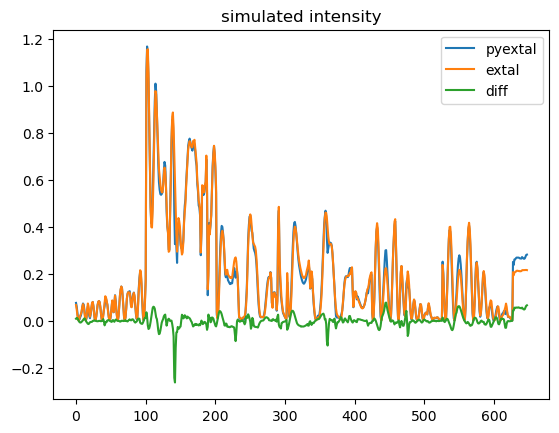

In [23]:
plt.plot(simCBED[fine.roi.mask], label='pyextal')
plt.plot(extal_sim[:,1], label='extal')
plt.plot(simCBED[fine.roi.mask] - extal_sim[:,1], label='diff')
plt.legend()
plt.title('simulated intensity')

(1, -1, -1): U 0.0471822 UA 0.0008318
(2, -2, -2): U 0.0009636 UA 0.0000000
Chi Square background for each disk: 3.51688


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([array([[[ 109.39624 ,   73.96656 ,   55.24126 ,   47.627796,
             28.129421,   44.214115,   78.700386,  110.32234 ,
            132.41826 ,  154.47206 ,  124.53743 ,   85.96586 ,
             73.45782 ,   49.395992,   72.80916 ,  133.79439 ,
            107.547386,  105.988945,   62.481163,   45.297016,
             69.40972 ,   95.42645 ,  131.38573 ,  137.13596 ,
            144.21326 ,   91.551636,   53.98436 ,   43.45992 ,
             58.647514,   79.8623  ,  105.55121 ,  134.29573 ,
            144.68329 ,  146.23495 ,  131.84833 ,   97.98572 ,
             65.26421 ,   41.86169 ,   32.3359  ,   57.956135,
            103.78283 ,  125.46804 ,  144.0162  ,  137.71368 ,
            135.45592 ,  113.192535,   76.3919  ,   56.962902,
             52.924446,   48.56352 ,   65.694786,   89.22204 ,
             92.1285  ,   82.132675,   71.80733 ,  133.27448 ,
            143.48962 ,  145.9666  ,   89.143394,   58.94282 ,
             50.56193 ,   52.458332,  105.96425 ,  137.

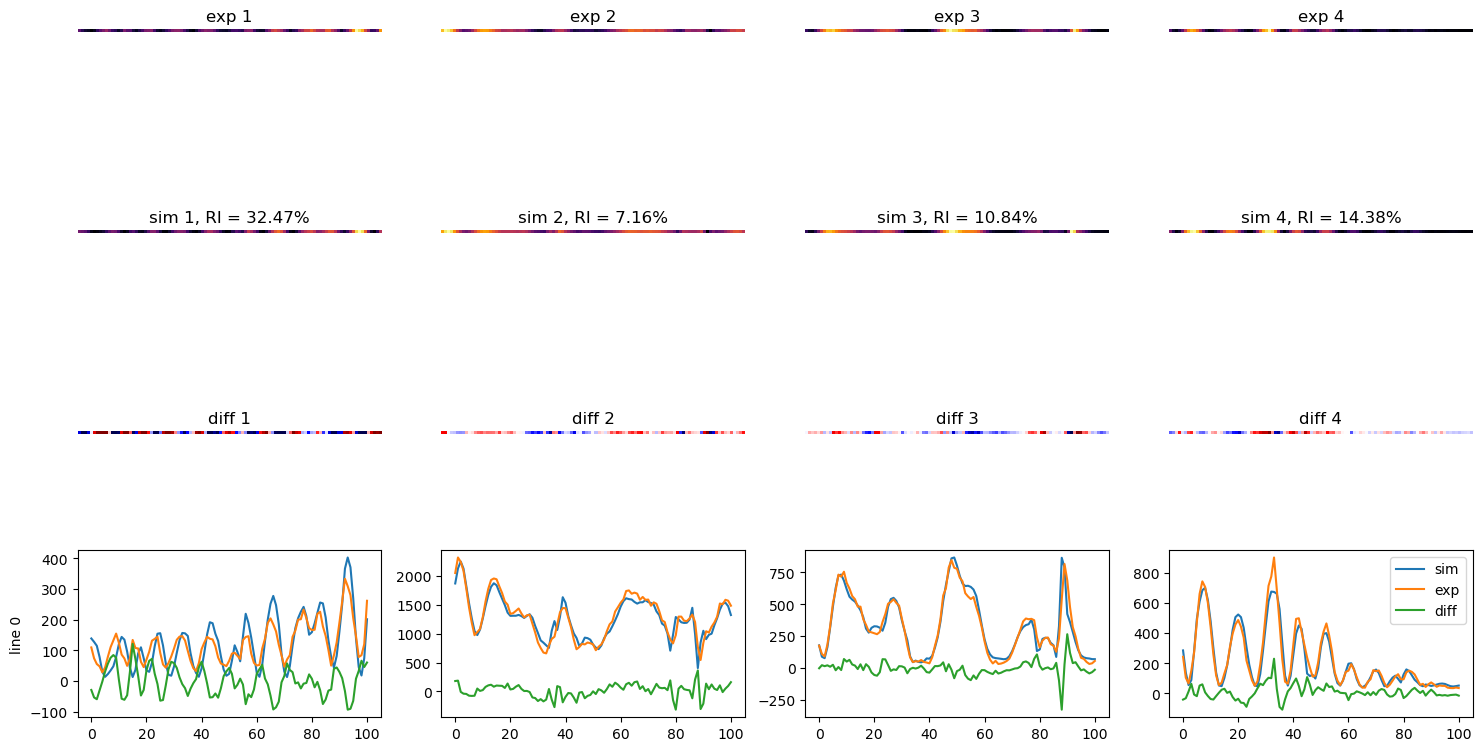

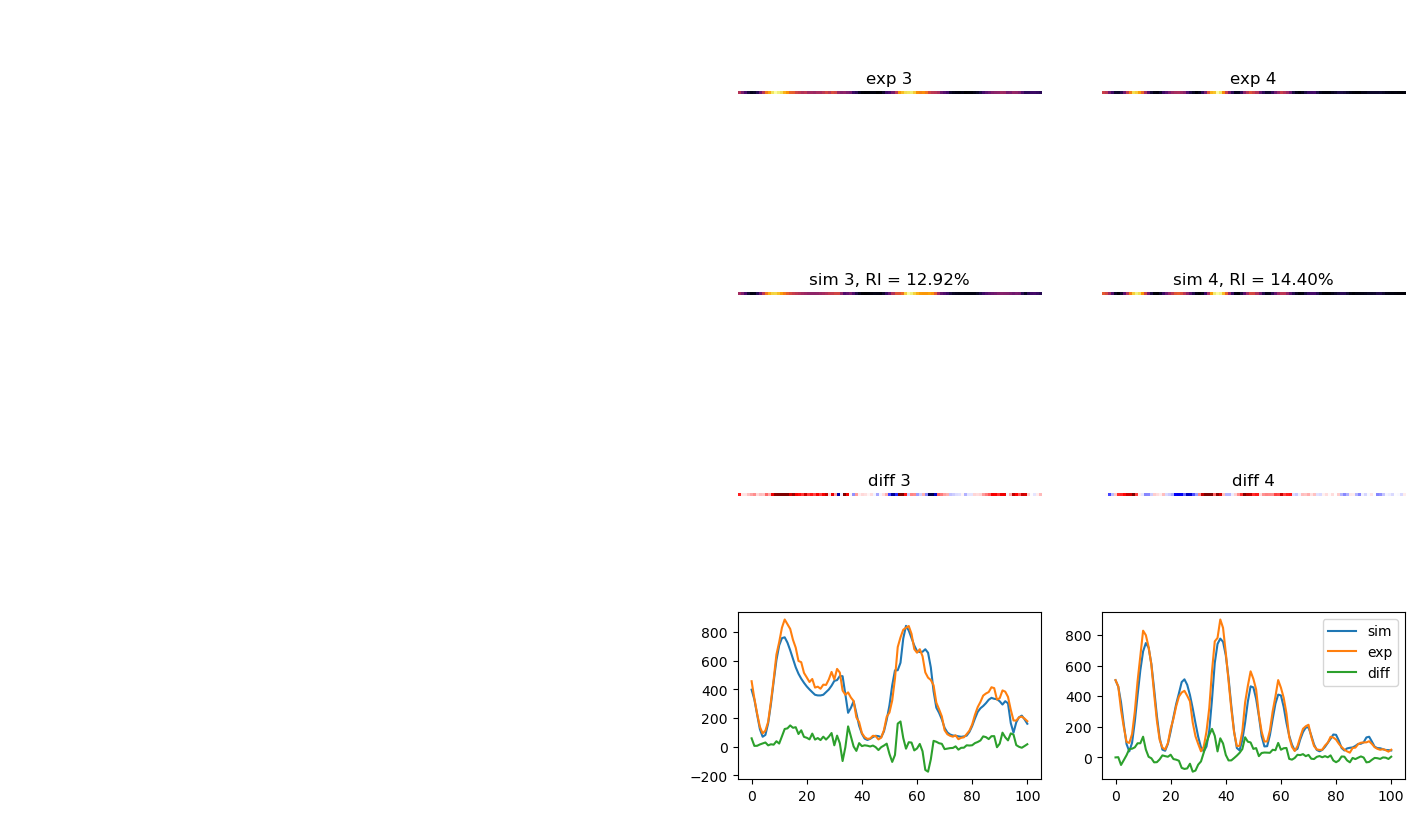

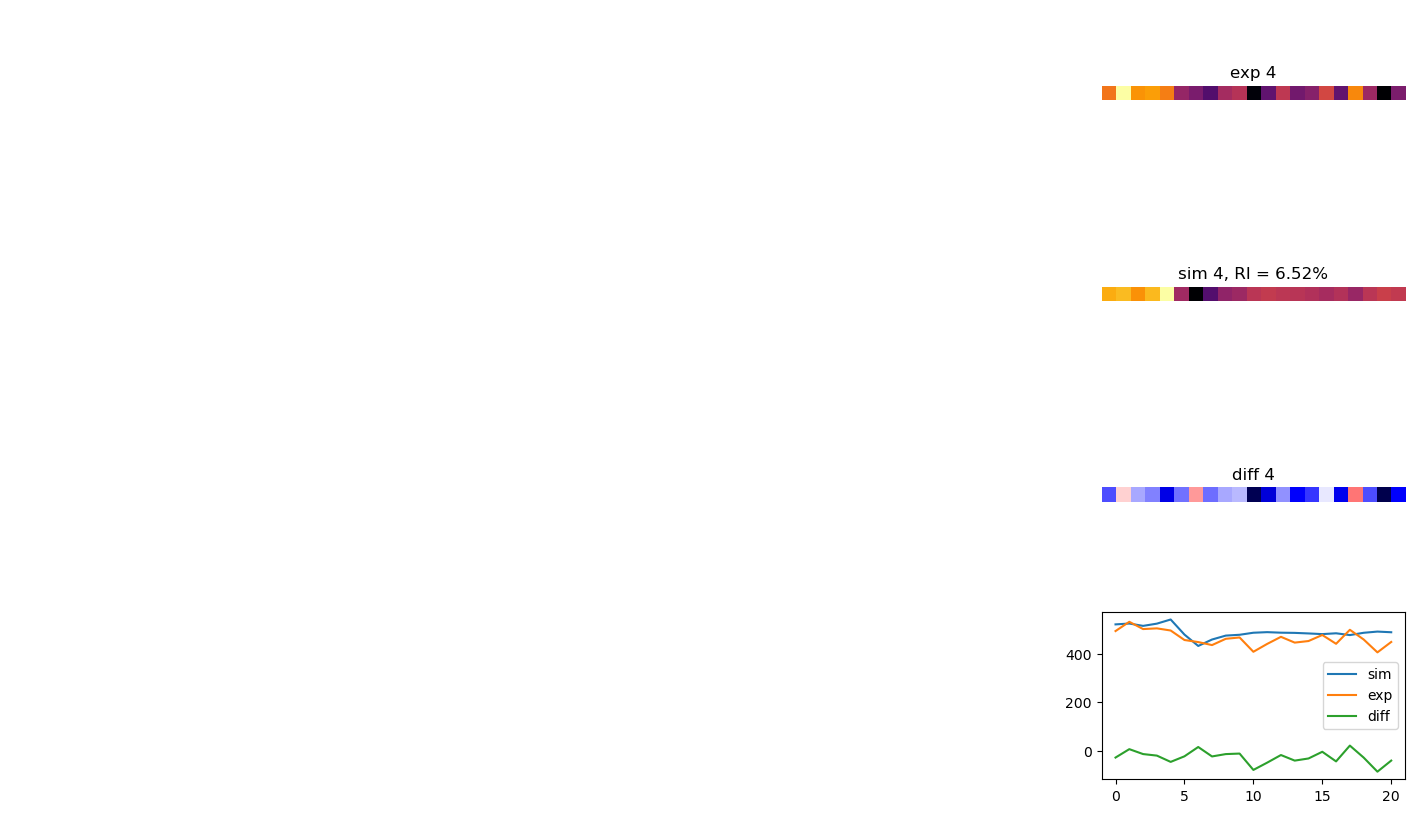

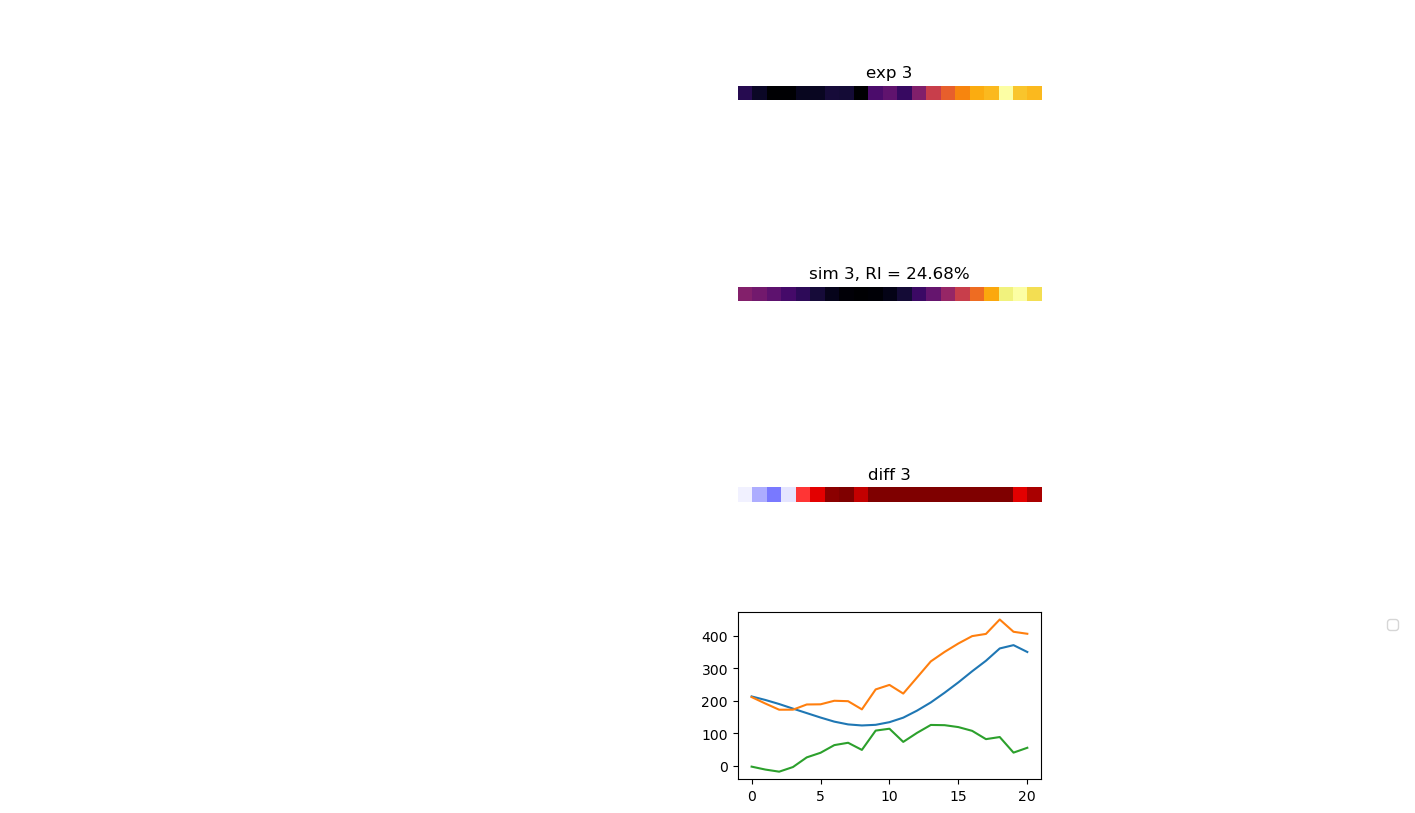

In [18]:
fine.getx0()
fine.display([0,])

start the refinement
- x0: initial guess for the structure factor, if not provided, use the structure factor save in fine (1,1,1,1) (bird's atomic scatter factor) if no previous fine refinement

In [15]:
%matplotlib qt
fine.optimize()
# fine.optimize()

setting the initial value and normalization range to:
beam: (1, -1, -1)
      lower       value       upper  
U : 4.5000000e-02   4.7182200e-02   5.0000000e-02
UA: 5.0000000e-04   8.3177800e-04   1.0000000e-03
------------------------------
beam: (2, -2, -2)
      lower       value       upper  
U : 9.0000000e-04   9.6364100e-04   1.1000000e-03
UA: 0.0000000e+00   0.0000000e+00   0.0000000e+00
------------------------------


MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


start optimization
normal:[[0.0471822  0.00083178]
 [0.00096364 0.        ]]
SF:
(1, -1, -1): 4.7182200e-02 8.3177800e-04
(2, -2, -2): 9.6364100e-04 0.0000000e+00


/home/hcni/project/bloch-python/src/pyextal/optimize.py:656: RuntimeWarning: invalid value encountered in divide
  return ((self.x0-self.x0Range[0])/(self.x0Range[1]-self.x0Range[0]))[self.sfMask]


thickness: 3430.84 gl: 226.91080 rotation: 44.77882
corner: -0.00237 -0.86979
GOF: 3.08907  func eval: 227
Error: 3.063747718685963  func eval: 227
********************
SF:
(1, -1, -1): 4.7291310e-02 8.3177800e-04
(2, -2, -2): 9.6364100e-04 0.0000000e+00
thickness: 3425.48 gl: 226.84112 rotation: 44.22193
corner: 1.22121 -2.95196
GOF: 2.79851  func eval: 513
Error: 2.77556872758709  func eval: 513
********************
SF:
(1, -1, -1): 4.7182200e-02 8.4836690e-04
(2, -2, -2): 9.6364100e-04 0.0000000e+00
thickness: 3430.83 gl: 226.91446 rotation: 44.21622
corner: 1.17192 -3.05009
GOF: 2.85847  func eval: 173
Error: 2.8350354804367317  func eval: 173
********************
SF:
(1, -1, -1): 4.7182200e-02 8.3177800e-04
(2, -2, -2): 9.6682305e-04 0.0000000e+00
thickness: 3430.87 gl: 226.91331 rotation: 44.21658
corner: 1.17304 -3.05064
GOF: 2.85320  func eval: 38
Error: 2.8298159740010247  func eval: 38
********************
SF:
(1, -1, -1): 4.7254940e-02 8.4283727e-04
(2, -2, -2): 9.6576237e-0

In [27]:
fine.errorFunc.background

array([[ 16.281023],
       [224.23517 ],
       [ 35.9021  ],
       [ 41.316162]], dtype=float32)

In [25]:
roi.kt2pixel(np.array([[12.1174, -12.1174, 25.7135]]))

array([[-46.35020645,  70.46945525]])

In [22]:
roi.transformDP(roi.kt2pixel(np.array([[12.1174, -12.1174, 25.7135]]))*roi.initPixsiz/roi.pixsiz + roi.dpCenter+roi.allshift)

array([[416.08639562, 460.65345052]])

### display the result
- lines: list of lines to display, each line is a row in the region of interest

(1, -1, -1): U 0.0473504 UA 0.0007937
(2, -2, -2): U 0.0009232 UA 0.0000000
Chi Square background for each disk: 2.77708


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


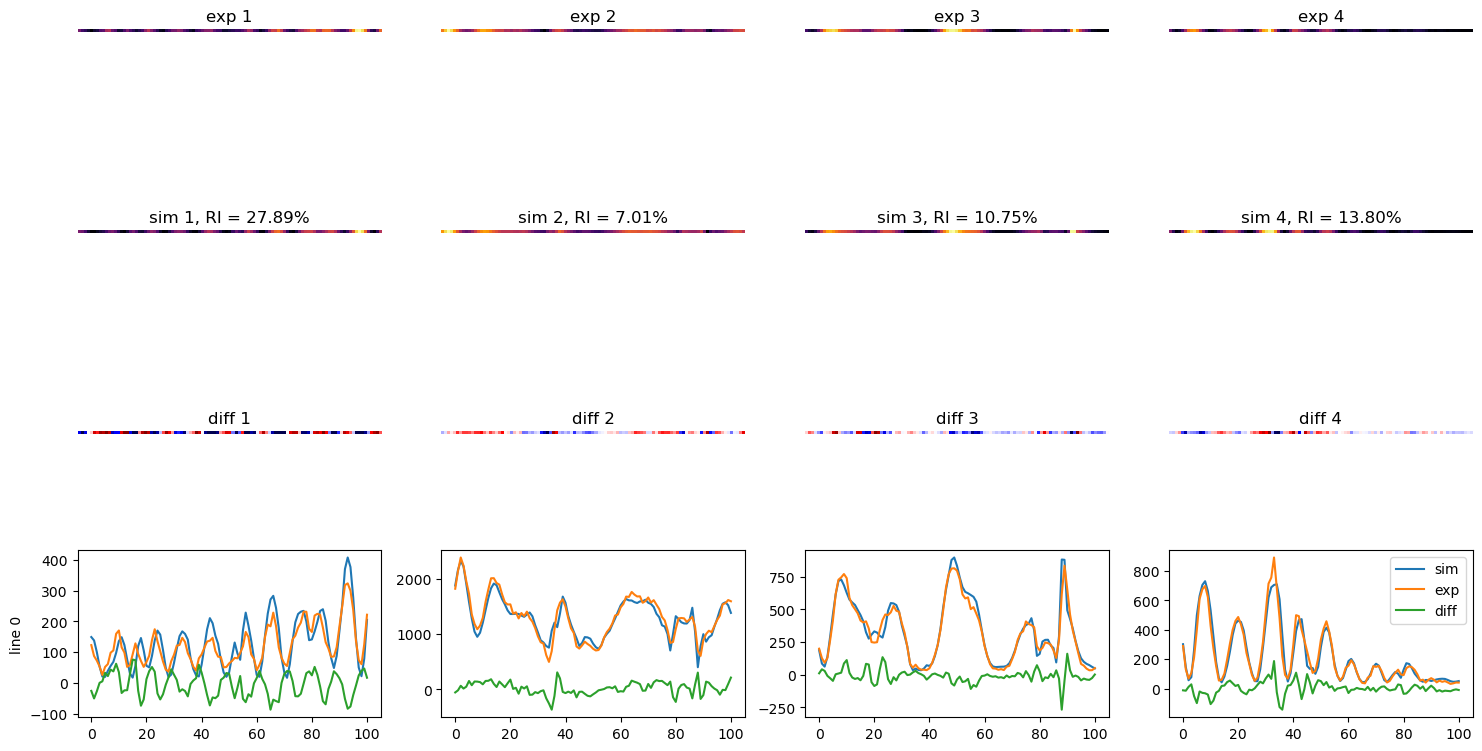

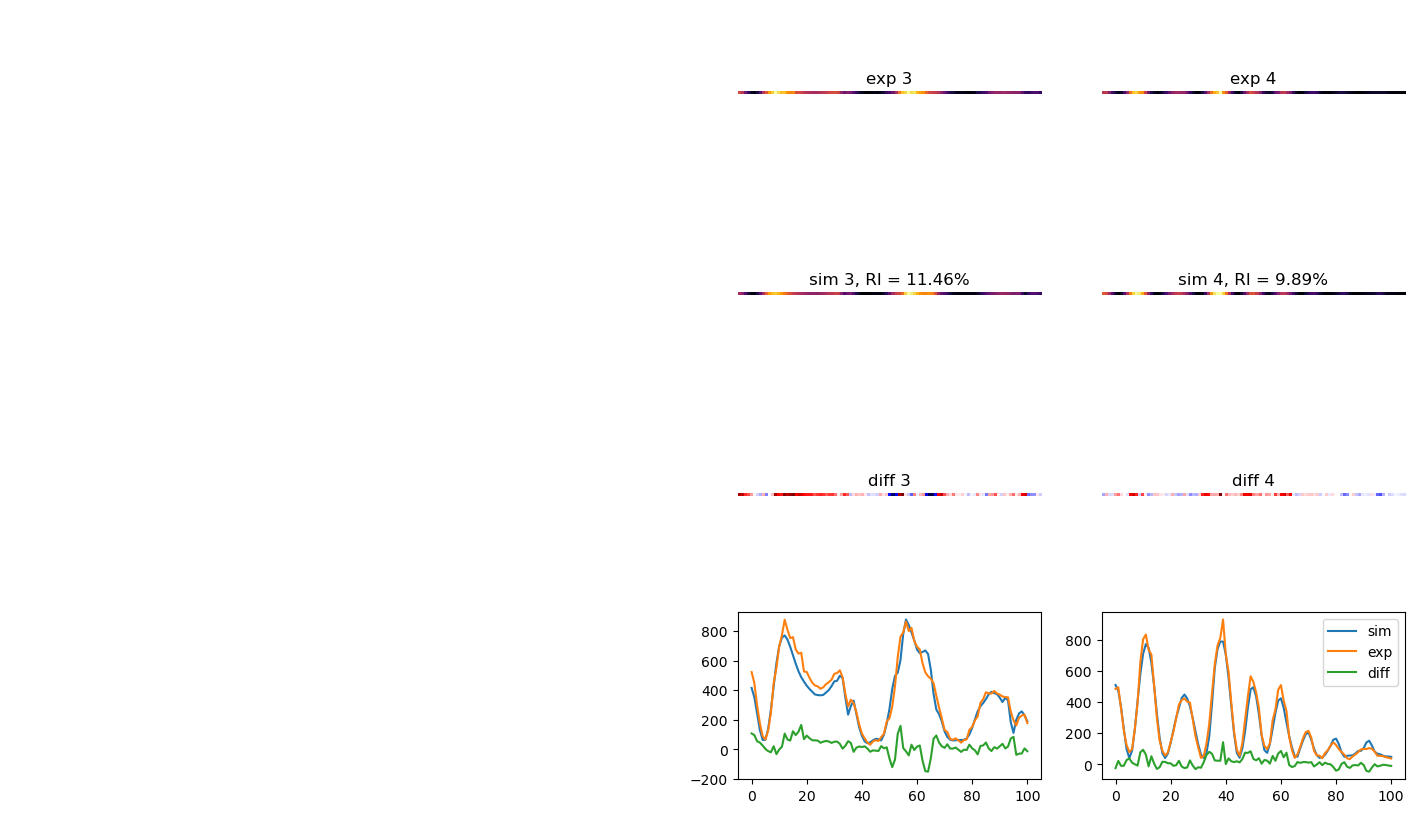

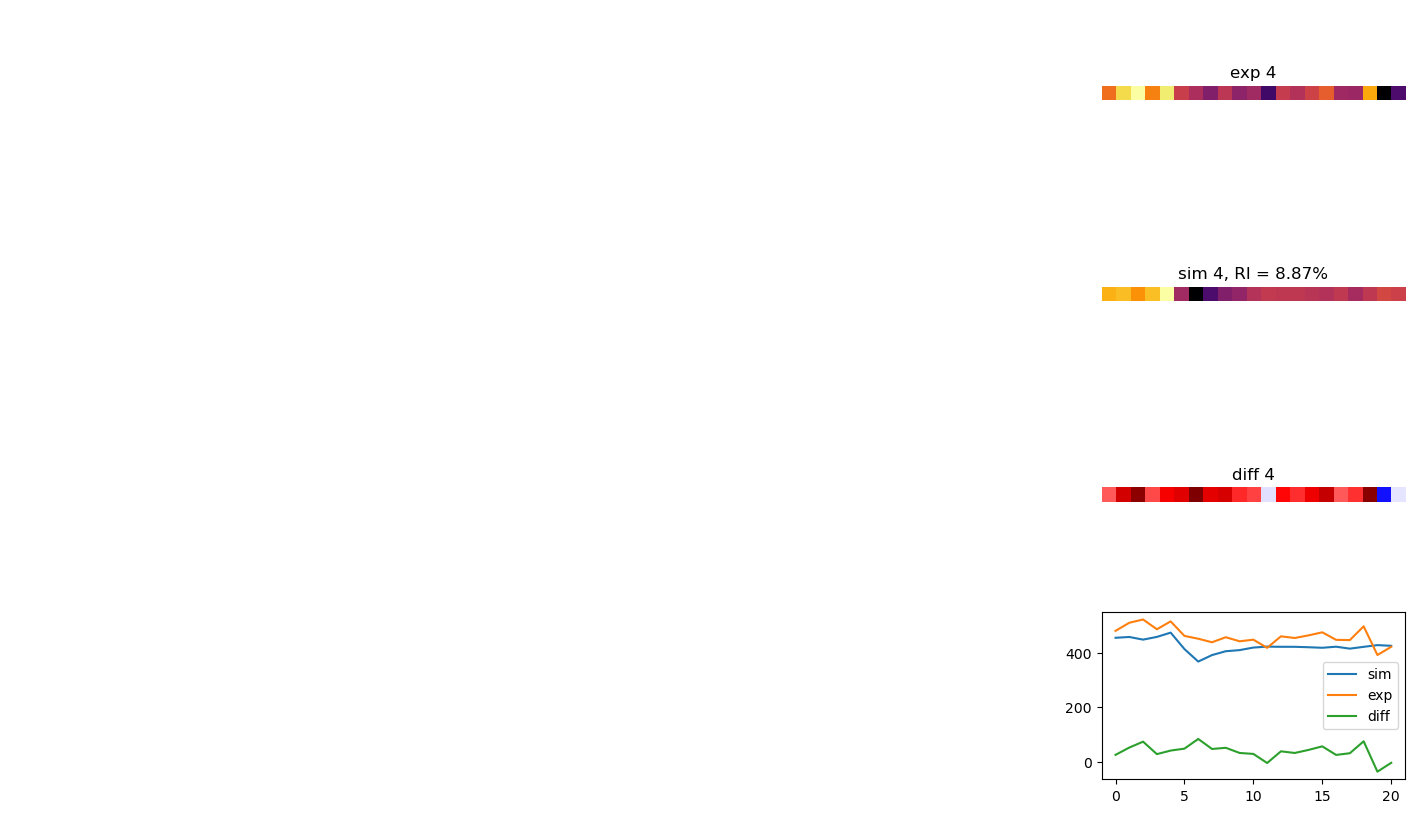

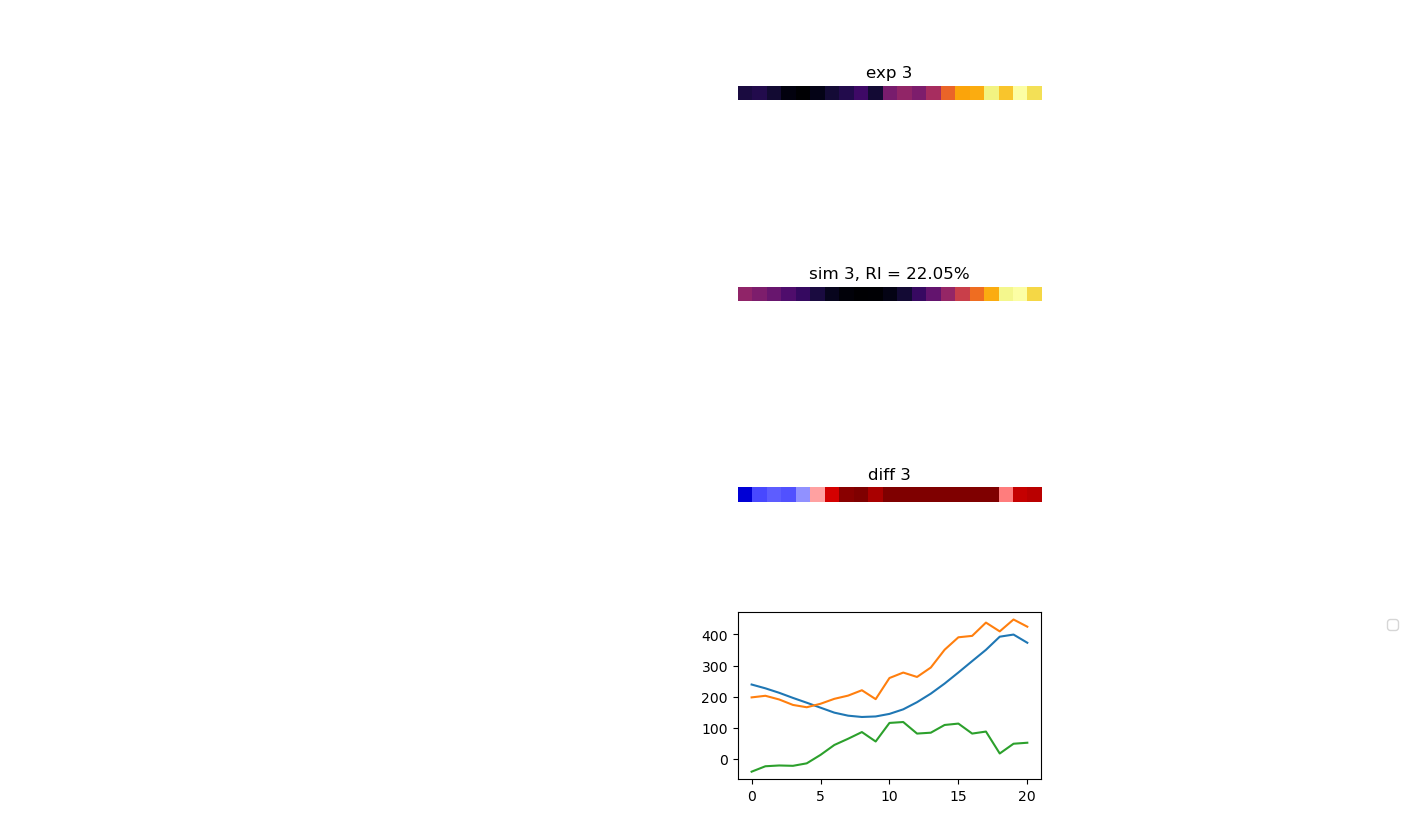

In [16]:
%matplotlib inline
regionExp, regionSim = fine.display([0,])

4

[array([[238.52796948, 103.22728499],
        [239.81723564, 104.55191141],
        [241.10650181, 105.87653784],
        [242.39576797, 107.20116426],
        [243.68503413, 108.52579069],
        [244.9743003 , 109.85041712],
        [246.26356646, 111.17504354],
        [247.55283262, 112.49966997],
        [248.84209879, 113.82429639],
        [250.13136495, 115.14892282],
        [251.42063111, 116.47354925],
        [252.70989727, 117.79817567],
        [253.99916344, 119.1228021 ],
        [255.2884296 , 120.44742852],
        [256.57769576, 121.77205495],
        [257.86696193, 123.09668137],
        [259.15622809, 124.4213078 ],
        [260.44549425, 125.74593423],
        [261.73476041, 127.07056065],
        [263.02402658, 128.39518708],
        [264.31329274, 129.7198135 ],
        [265.6025589 , 131.04443993],
        [266.89182507, 132.36906636],
        [268.18109123, 133.69369278],
        [269.47035739, 135.01831921],
        [270.75962356, 136.34294563],
        [272

In [20]:
sampling = roi.getSampling()
for idx, (sim, exp) in enumerate(zip(regionSim, regionExp)):
    np.save(f'../box/Si_systematics/regionSim{idx}.npy', sim)
    np.save(f'../box/Si_systematics/regionExp{idx}.npy', exp)
    np.save(f'../box/Si_systematics/sampling{idx}.npy', sampling[idx])
    

In [28]:
fine.errorFunc(fine.evaluateParam(), fine.roi.templates, fine.roi.mask)

2779.2666

In [20]:
print(f'kt: 12.1174, -12.1174, 25.7133 = {roi.transformDP(roi.kt2pixel(np.array([[12.1174, -12.1174, 25.7133]]))*roi.initPixsiz/roi.pixsiz + roi.dpCenter+roi.allshift)}')
print(f'gl: {roi.gl} rotation: {roi.rotation}')
print(f'thickness: {fine.thickness} ')
print(f'norm:: {fine.errorFunc.scale}')
print(f'background: {fine.errorFunc.background}')


kt: 12.1174, -12.1174, 25.7133 = [[416.10777583 456.98849595]]
gl: 226.77354262586226 rotation: 44.23690197629627
thickness: 3421.6441471701332 
norm:: 1797.220458984375
background: [[ 16.015116]
 [222.49435 ]
 [ 33.66471 ]
 [ 38.898853]]


In [22]:
from pyextal.callBloch import terminate
terminate()